# Build HDF5 Container Input for GCN from Methylation Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
plt.rc('font', family='Times New Roman')
import h5py
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Load Sample Methylation Matrix

In [2]:
meth_all_samples = pd.read_csv('../../data/pancancer/TCGA/methylation/methylation_sample_matrix_450_tcgafiveprimeT_1000bp.tsv',
                               sep='\t')
# rename first column to 'Symbol'
meth_all_samples.columns = ['Symbol'] + meth_all_samples.columns[1:].tolist()
meth_all_samples.head()

,Symbol,TCGA-AB-2995-03A-01D-0741-05|laml|mean_beta_value_promoter,TCGA-AB-2995-03A-01D-0741-05|laml|support_promoter,TCGA-2E-A9G8-01A-11D-A409-05|ucec|mean_beta_value_promoter,TCGA-2E-A9G8-01A-11D-A409-05|ucec|support_promoter,TCGA-AB-2967-03A-01D-0742-05|laml|mean_beta_value_promoter,TCGA-AB-2967-03A-01D-0742-05|laml|support_promoter,TCGA-DQ-7588-01A-11D-2079-05|hnsc|mean_beta_value_promoter,TCGA-DQ-7588-01A-11D-2079-05|hnsc|support_promoter,TCGA-AB-2873-03A-01D-0742-05|laml|mean_beta_value_promoter,...,TCGA-A6-5656-01A-21D-A27A-05|coad|mean_beta_value_promoter,TCGA-A6-5656-01A-21D-A27A-05|coad|support_promoter,TCGA-D5-6930-01A-11D-1926-05|coad|mean_beta_value_promoter,TCGA-D5-6930-01A-11D-1926-05|coad|support_promoter,TCGA-A6-5656-01B-02D-A27A-05|coad|mean_beta_value_promoter,TCGA-A6-5656-01B-02D-A27A-05|coad|support_promoter,TCGA-AF-A56K-01A-32D-A39G-05|read|mean_beta_value_promoter,TCGA-AF-A56K-01A-32D-A39G-05|read|support_promoter,TCGA-A6-6652-01A-11D-1772-05|coad|mean_beta_value_promoter,TCGA-A6-6652-01A-11D-1772-05|coad|support_promoter
0,A1BG,0.805425,5,0.320773,5.0,0.877443,5.0,0.723260,5.0,0.916288,...,0.476794,5,0.756011,5,0.642131,5.0,0.430189,5,0.587315,5.0
1,A1BG-AS1,0.032549,4,0.025817,4.0,0.102225,4.0,0.050617,4.0,0.024369,...,0.487295,4,0.308283,4,0.319729,4.0,0.211204,4,0.270076,4.0
2,A1CF,0.881828,3,0.250301,3.0,0.799332,3.0,0.462136,3.0,0.754143,...,0.310399,3,0.614371,3,0.493545,3.0,0.434046,3,0.349528,3.0
3,A2M,0.582412,2,0.464732,2.0,0.531249,2.0,0.529455,2.0,0.586573,...,0.483539,2,0.580142,2,0.452237,2.0,0.406105,2,0.521644,2.0
4,A2ML1,0.847787,4,0.297757,4.0,0.873137,4.0,0.311103,4.0,0.847923,...,0.292426,4,0.720376,4,0.492707,4.0,0.381383,4,0.412641,4.0


In [3]:
barcodes = [n.split('|')[0] for n in meth_all_samples.columns[1:] if "mean_beta_value_promoter" in n]
sample_types = [i.split('-')[3] for i in barcodes]
for st in np.unique(sample_types):
    print ("{}: {}".format(st, sample_types.count(st)))

# when the fourth part of the barcode starts with 0, it has to be tumor sample
tumor_sample_cols = ['Symbol'] + [i for i in meth_all_samples.columns[1:] if i.split('|')[0].split('-')[3].startswith('0')]
meth_all_tumor_samples = meth_all_samples[tumor_sample_cols]

01A: 3810
01B: 86
01C: 7
02A: 17
02B: 1
03A: 140
05A: 1
06A: 9
11A: 473
11B: 21


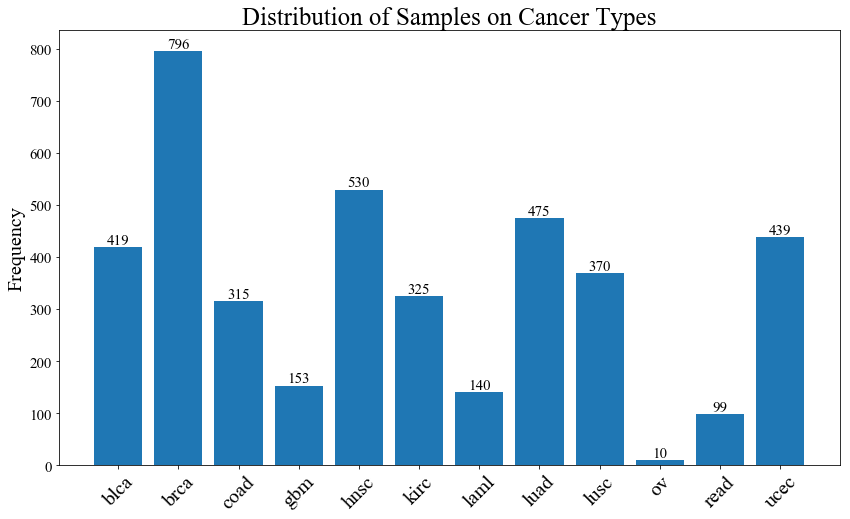

In [4]:
c_types = [n.split('|')[1] for n in meth_all_tumor_samples.columns[1:] if "mean_beta_value_promoter" in n]
unique, counts = np.unique(c_types, return_counts=True)
fig = plt.figure(figsize=(14, 8))
b = plt.bar(np.arange(counts.shape[0]), counts)
plt.xticks(np.arange(counts.shape[0]), unique, rotation=45, fontsize=20)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.title('Distribution of Samples on Cancer Types', fontsize=25)

# Add counts above the two bar graphs
for rect in b:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom', size=15)

fig.savefig('../../data/pancancer/TCGA/methylation/samples_per_cancertype.svg')

In [5]:
barcodes = [n.split('|')[0] for n in meth_all_tumor_samples.columns[1:] if "mean_beta_value_promoter" in n]
sample_types = [i.split('-')[3] for i in barcodes]
for st in np.unique(sample_types):
    print ("{}: {}".format(st, sample_types.count(st)))

01A: 3810
01B: 86
01C: 7
02A: 17
02B: 1
03A: 140
05A: 1
06A: 9


## 2. Mean Samples Across Cancer Types

In [6]:

# first, transpose and add column with cancer type
meth_t = meth_all_tumor_samples.T
meth_t['cancer_type'] = [None] + [i[1] for i in meth_t.index.str.split('|')[1:]]

# remove everything that is not a promoter beta value (remove support and gene body methylation)
meth_prom_only = meth_t[meth_t.index.str.contains('beta_value_promoter')]
meth_gene_only = meth_t[meth_t.index.str.contains('beta_value_gene')]

# compute mean across all cancer types
meth_prom_only_mean = meth_prom_only.fillna(0).groupby('cancer_type').mean().T
meth_prom_only_mean['Symbol'] = meth_all_tumor_samples.Symbol # reintroduce gene names
meth_prom_only_mean.set_index('Symbol', inplace=True) # set them as index

if meth_gene_only.shape[0] > 0:
    meth_gene_only_mean = meth_gene_only.fillna(0).groupby('cancer_type').mean().T
    meth_gene_only_mean['Symbol'] = meth_all_tumor_samples.Symbol # reintroduce gene names
    meth_gene_only_mean.set_index('Symbol', inplace=True) # set them as index

In [7]:
# construct dataframe with both, methylation for the promoters and gene bodies
ctypes = meth_prom_only_mean.columns
meth_prom_only_mean['kind'] = 'Promoter'
if meth_gene_only.shape[0] > 0:
    meth_gene_only_mean['kind'] = 'Gene Body'
    both = pd.concat((meth_prom_only_mean, meth_gene_only_mean))
else:
    both = meth_prom_only_mean
# convert to long format
long_format = pd.melt(both, id_vars=['Symbol', 'kind'], value_vars=list(unique))

In [8]:
# plot violinplot if we have gene body methylation too
if meth_gene_only.shape[0] > 0:
    fig = plt.figure(figsize=(20, 10))
    ax = seaborn.violinplot(x='cancer_type', y='value', hue='kind', data=long_format, dodge=True)
    plt.xlabel('')
    plt.ylabel('Beta Value', fontsize=20)
    plt.title('DNA Methylation Across Cancer Types', fontsize=30)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=15)
    plt.setp(ax.get_legend().get_texts(), fontsize='20')
    _ = plt.setp(ax.get_legend().get_title(), fontsize='0') # make title of legend disappear
    fig.savefig('../../data/pancancer/TCGA/methylation/beta_values_cancertype.png')

In [9]:
# now, get the same means for the support
sup_prom_only = meth_t[meth_t.index.str.contains('support_promoter')]
sup_gene_only = meth_t[meth_t.index.str.contains('support_gene')]

# compute mean across all cancer types
sup_prom_only_mean = sup_prom_only.fillna(0).groupby('cancer_type').mean().T
sup_prom_only_mean['Symbol'] = meth_all_tumor_samples.Symbol # reintroduce gene names
sup_prom_only_mean.set_index('Symbol', inplace=True) # set them as index

if sup_gene_only.shape[0] > 0:
    sup_gene_only_mean = sup_gene_only.fillna(0).groupby('cancer_type').mean().T
    sup_gene_only_mean['Symbol'] = meth_all_tumor_samples.Symbol # reintroduce gene names
    sup_gene_only_mean.set_index('Symbol', inplace=True) # set them as index

In [10]:
# construct dataframe with both, methylation for the promoters and gene bodies
ctypes = sup_prom_only_mean.columns
sup_prom_only_mean['kind'] = 'Promoter'
if sup_gene_only.shape[0] > 0:
    sup_gene_only_mean['kind'] = 'Gene Body'
    both = pd.concat((sup_prom_only_mean, sup_gene_only_mean))
else:
    both = sup_prom_only_mean

# convert to long format
long_format_sup = pd.melt(both, id_vars=['Symbol', 'kind'], value_vars=list(unique))

In [11]:
# plot violinplot
if sup_gene_only.shape[0] > 0:
    fig = plt.figure(figsize=(20, 10))
    ax = seaborn.boxplot(x='cancer_type', y='value', hue='kind', data=long_format_sup, dodge=True)
    plt.xlabel('')
    plt.ylabel('# of CpG sites in Region', fontsize=20)
    plt.title('CpG Sites Across Cancer Types', fontsize=30)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=15)
    plt.setp(ax.get_legend().get_texts(), fontsize='20')
    _ = plt.setp(ax.get_legend().get_title(), fontsize='0') # make title of legend disappear
    fig.savefig('support_means.png')

In [12]:
if meth_gene_only.shape[0] > 0:
    meth_prom_only_mean.to_csv('../../data/pancancer/TCGA/methylation/methylation_matrix_promoters_cancers.tsv', sep='\t')
    meth_gene_only_mean.to_csv('../../data/pancancer/TCGA/methylation/methylation_matrix_genes_cancers.tsv', sep='\t')
else:
    meth_prom_only_mean.to_csv('../../data/pancancer/TCGA/methylation/methylation_matrix_promoters_cancers_tcgaannot.tsv', sep='\t')

## 3. Check Methylation for Oncogenes & Tumor Suppressors

In [13]:
meth_prom_only_mean[meth_prom_only_mean.index == 'BRCA2']

cancer_type,blca,brca,coad,gbm,hnsc,kirc,laml,luad,lusc,ov,read,ucec,kind
Symbol,,,,,,,,,,,,,
BRCA2,0.0264,0.028963,0.029917,0.027939,0.027612,0.026142,0.021221,0.050978,0.025785,0.024825,0.026558,0.027919,Promoter


Got 125 cancer genes
Other       28236
TSG            66
Oncogene       50
Name: type, dtype: int64


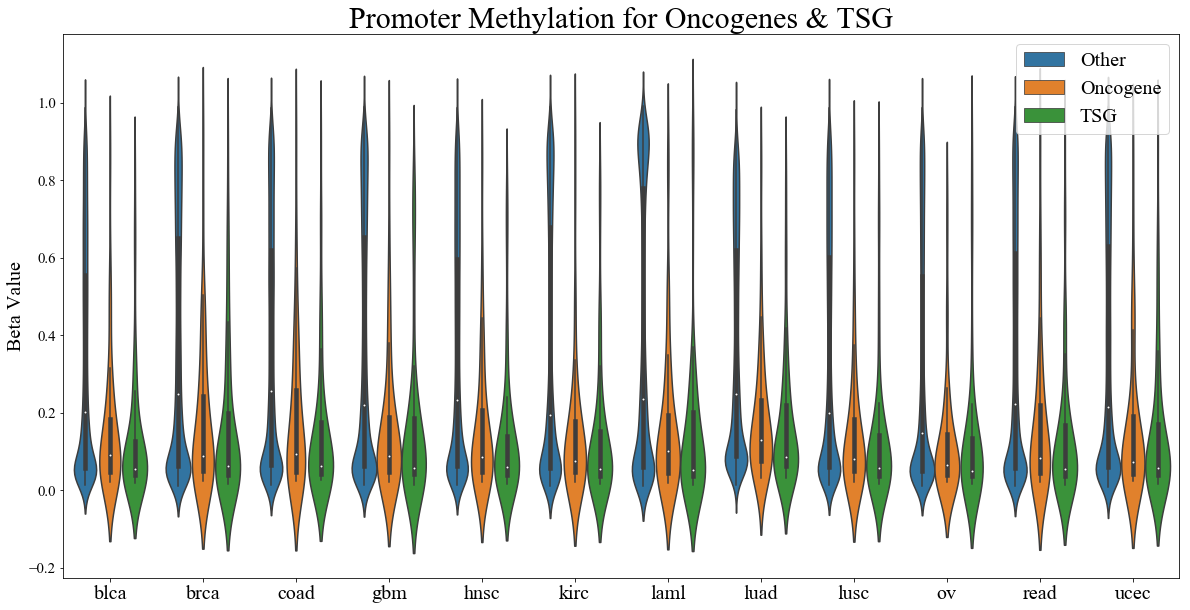

In [18]:
cancer_genes = pd.read_csv('../../data/pancancer/vogelstein/table_s2a.csv', sep='\t', header=0)
cancer_genes.columns = [i.strip('*') for i in cancer_genes.columns]
oncogenes = cancer_genes[cancer_genes.Classification == "Oncogene"]
suppressors = cancer_genes[cancer_genes.Classification == "TSG"]
print ("Got {} cancer genes".format(cancer_genes.shape[0]))

meth_prom_only_mean_onco = meth_prom_only_mean
meth_prom_only_mean_onco.drop('kind', axis=1, inplace=True, errors='ignore')
meth_prom_only_mean_onco['type'] = 'Other'
meth_prom_only_mean_onco.loc[meth_prom_only_mean_onco.index.isin(oncogenes['Gene Symbol']), 'type'] = 'Oncogene'
meth_prom_only_mean_onco.loc[meth_prom_only_mean_onco.index.isin(suppressors['Gene Symbol']), 'type'] = 'TSG'
print (meth_prom_only_mean_onco.type.value_counts())

# plot
fig = plt.figure(figsize=(20, 10))
ax = sns.violinplot(data=pd.melt(meth_prom_only_mean_onco, id_vars=['type']),
                        x='cancer_type',
                        y='value',
                        hue='type',
                        dodge=True,
                        scale_hue=True
                       )
plt.xlabel('')
plt.ylabel('Beta Value', fontsize=20)
plt.title('Promoter Methylation for Oncogenes & TSG', fontsize=30)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.legend(loc='upper right', fontsize=20)
fig.savefig('../../data/pancancer/TCGA/methylation/oncogene_TSG_promoter_methylation.svg')
fig.savefig('../../data/pancancer/TCGA/methylation/oncogene_TSG_promoter_methylation.png', dpi=300)

/home/sasse/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


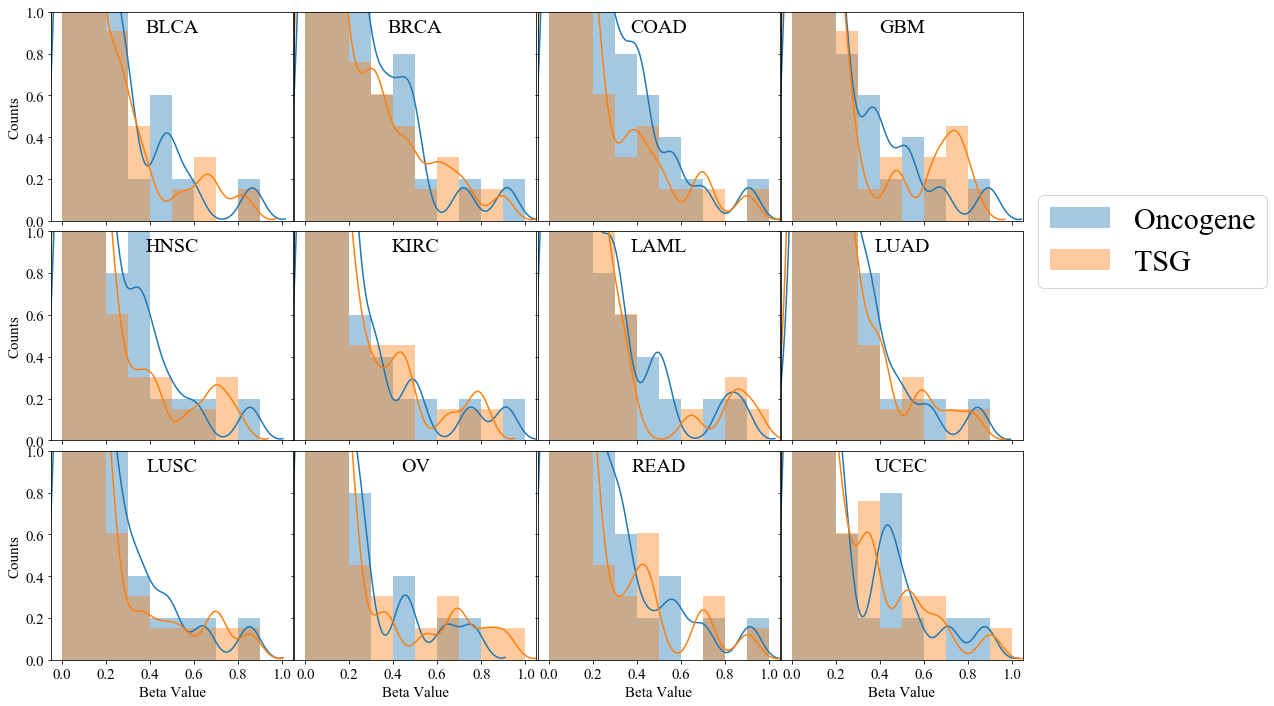

In [28]:
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 1],
         wspace=0.005, hspace=0.05, top=0.95, bottom=0.05, left=0.17, right=0.845)

count = 1
bins = np.linspace(0, 1, 11)
for ctype in meth_prom_only_mean_onco.columns[:-1]:
    plt.subplot(gs[count-1])
    sns.distplot(a=meth_prom_only_mean_onco.loc[meth_prom_only_mean_onco.type == 'Oncogene', ctype],
                 label='Oncogene', kde=True, bins=bins, hist_kws={'alpha':0.4}, kde_kws={'bw':0.05})
    sns.distplot(a=meth_prom_only_mean_onco.loc[meth_prom_only_mean_onco.type == 'TSG', ctype],
                 label='TSG', kde=True, bins=bins, hist_kws={'alpha':0.4}, kde_kws={'bw':0.05})
    #sns.kdeplot(data=meth_prom_mean.loc[meth_prom_mean.type == 'Other', ctype], label='Other', kde=True,
    #             hist_kws={"alpha": .1, "color": "g"}, kde_kws={'alpha':0.3}
    #            )
    plt.title(ctype.upper(), pad=-20, size=20)
    plt.ylim([0, 1])
    plt.xlim([-0.05, 1.05])
    if count in [1, 5, 9]:
        plt.ylabel('Counts', fontsize=15)
        plt.setp(plt.gca().get_yticklabels(), size=15)
    else:
        plt.ylabel('')
        plt.setp(plt.gca().get_yticklabels(), visible=False)
    if count in [9, 10, 11, 12]:
        plt.xlabel('Beta Value', fontsize=15)
        plt.setp(plt.gca().get_xticklabels(), size=15)
    else:
        plt.xlabel('')
        plt.setp(plt.gca().get_xticklabels(), visible=False)
        #plt.setp(plt.gca().get_yticklabels(), visible=False)
    count += 1
plt.legend(loc='center left', bbox_to_anchor=(1, 2), fontsize=30)
#plt.title('DNA Methylation Across Cancer Types', fontsize=30, loc='Center')
fig.savefig('../../data/pancancer/TCGA/methylation/oncogene_TSG_histograms.svg')

In [22]:
s = meth_prom_only_mean.brca.idxmax()
meth_prom_only_mean['mean_meth'] = meth_prom_only_mean.drop('type', axis=1).mean(axis=1)
meth_prom_only_mean.sort_values(by='mean_meth', ascending=False).head(100)

cancer_type,blca,brca,coad,gbm,hnsc,kirc,laml,luad,lusc,ov,read,ucec,type,mean_meth
Symbol,,,,,,,,,,,,,,
CTC-429L19.3,0.987351,0.987929,0.987064,0.989274,0.987235,0.987537,0.991419,0.981234,0.985261,0.986994,0.990223,0.986952,Other,0.987373
SPDYE1,0.977814,0.983934,0.986548,0.988455,0.985135,0.988925,0.990010,0.979587,0.984239,0.984037,0.987816,0.987823,Other,0.985360
RP11-12D24.7,0.980000,0.986581,0.983599,0.985979,0.984973,0.987573,0.988852,0.979057,0.984451,0.981790,0.987877,0.984409,Other,0.984595
MIR6750,0.985534,0.985846,0.984455,0.986221,0.986134,0.987041,0.988561,0.980791,0.984658,0.968356,0.987381,0.983945,Other,0.984077
RP11-397E7.3,0.983246,0.984791,0.983160,0.985267,0.984196,0.985827,0.986612,0.977328,0.983731,0.978577,0.985390,0.982920,Other,0.983420
CTD-2587H24.14,0.984097,0.985848,0.980265,0.970005,0.984854,0.987637,0.987962,0.977339,0.979864,0.984556,0.987678,0.984517,Other,0.982885
RP11-266J6.2,0.982773,0.985491,0.982630,0.979008,0.981425,0.984789,0.988356,0.975376,0.977728,0.981497,0.985557,0.983734,Other,0.982364
RP4-669P10.16,0.980003,0.983498,0.980632,0.979435,0.982075,0.984444,0.986403,0.979572,0.980831,0.972493,0.984728,0.981991,Other,0.981342
CTD-2537I9.18,0.978131,0.982841,0.981441,0.979609,0.980196,0.981821,0.985035,0.968170,0.972128,0.980300,0.985372,0.979703,Other,0.979562


## 4. Integrate Methylation into HDF5 container

In [17]:
# load Container
data_file = '../../data/pancancer/iref_multiomics_norm_ncglabels.h5'

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

In [18]:
y_val.shape, val_mask.shape

((12129, 1), (12129,))

In [19]:
# first, bring node names to DF
nodes_df = pd.DataFrame(node_names, columns=['ensembl_id', 'name'])
nodes_df.set_index('ensembl_id', inplace=True)

# add gene body and promoter information
if meth_gene_only.shape[0] > 0:
    meth_mean_all = pd.concat((meth_prom_only_mean, meth_gene_only_mean), axis=1)
else:
    meth_mean_all = meth_prom_only_mean
features_all = nodes_df.join(meth_mean_all, on='name')

num_of_zero_nodes = features_all.isnull().any(axis=1).sum()
print ("{} out of {} nodes don't have any features assigned".format(num_of_zero_nodes, network.shape[0]))
print ("--> left with valid scores for {} genes".format(network.shape[0]-num_of_zero_nodes))

# put 0 for missing data and remove name columns
features_all.fillna(0, inplace=True)
features_all.drop(['name', 'kind', 'type'], axis=1, inplace=True, errors='ignore')

1161 out of 12129 nodes don't have any features assigned
--> left with valid scores for 10968 genes


In [20]:
# get also feature dfs for promoters and genes separately
features_prom = nodes_df.join(meth_prom_only_mean, on='name')
if meth_gene_only.shape[0] > 0:
    features_gene = nodes_df.join(meth_gene_only_mean, on='name')
    features_gene.fillna(0, inplace=True)
    features_gene.drop(['name', 'kind'], axis=1, inplace=True, errors='ignore')

# put 0 for missing data and remove name columns
features_prom.fillna(0, inplace=True)
features_prom.drop(['name', 'type'], axis=1, inplace=True, errors='ignore')


In [21]:
def write_hdf5_container(fname, adj, F, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, feature_names):
    f = h5py.File(fname, 'w')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('network', data=adj, shape=adj.shape)
    f.create_dataset('features', data=F, shape=F.shape)
    f.create_dataset('gene_names', data=node_names, dtype=string_dt)
    f.create_dataset('y_train', data=y_train, shape=y_train.shape)
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)
    f.create_dataset('y_test', data=y_test, shape=y_test.shape)
    f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
    f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
    f.create_dataset('feature_names', data=np.array(feature_names, dtype=object), dtype=string_dt)
    f.close()

    print ("Container written to {}".format(fname))

In [22]:
features = features_all.as_matrix()
fnames = features_all.columns
if meth_gene_only.shape[0] > 0:
    write_hdf5_container('../../data/pancancer/iref_methylation_450k1000bpprom_all.h5',
                         network, features, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, fnames)
else:
    write_hdf5_container('../../data/pancancer/iref_methylation_450k1000bpprom.h5',
                     network, features, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, fnames)

Container written to ../../data/pancancer/iref_methylation_450k1000bpprom.h5


In [23]:
if meth_gene_only.shape[0] > 0:
    features = features_prom.as_matrix()
    fnames = features_prom.columns
    write_hdf5_container('../../data/pancancer/iref_methylation_450k_1000bpprom.h5',
                         network, features, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, fnames)

In [24]:
if meth_gene_only.shape[0] > 0:
    features = features_gene.as_matrix()
    fnames = features_gene.columns
    write_hdf5_container('../../data/pancancer/iref_methylation_450k_genebody.h5',
                         network, features, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, list(c_types))

## Compute Embedding of Methylation Samples

In [25]:
meth_no_sup_cols = ['Symbol'] + [n for n in meth_all_samples.columns[1:] if "mean_beta_value_promoter" in n]
meth_samplewise = meth_all_samples[meth_no_sup_cols].dropna().set_index('Symbol').T
embedding = TSNE(n_components=2).fit_transform(meth_samplewise.drop(['cancer_type'], axis=1, errors='ignore'))

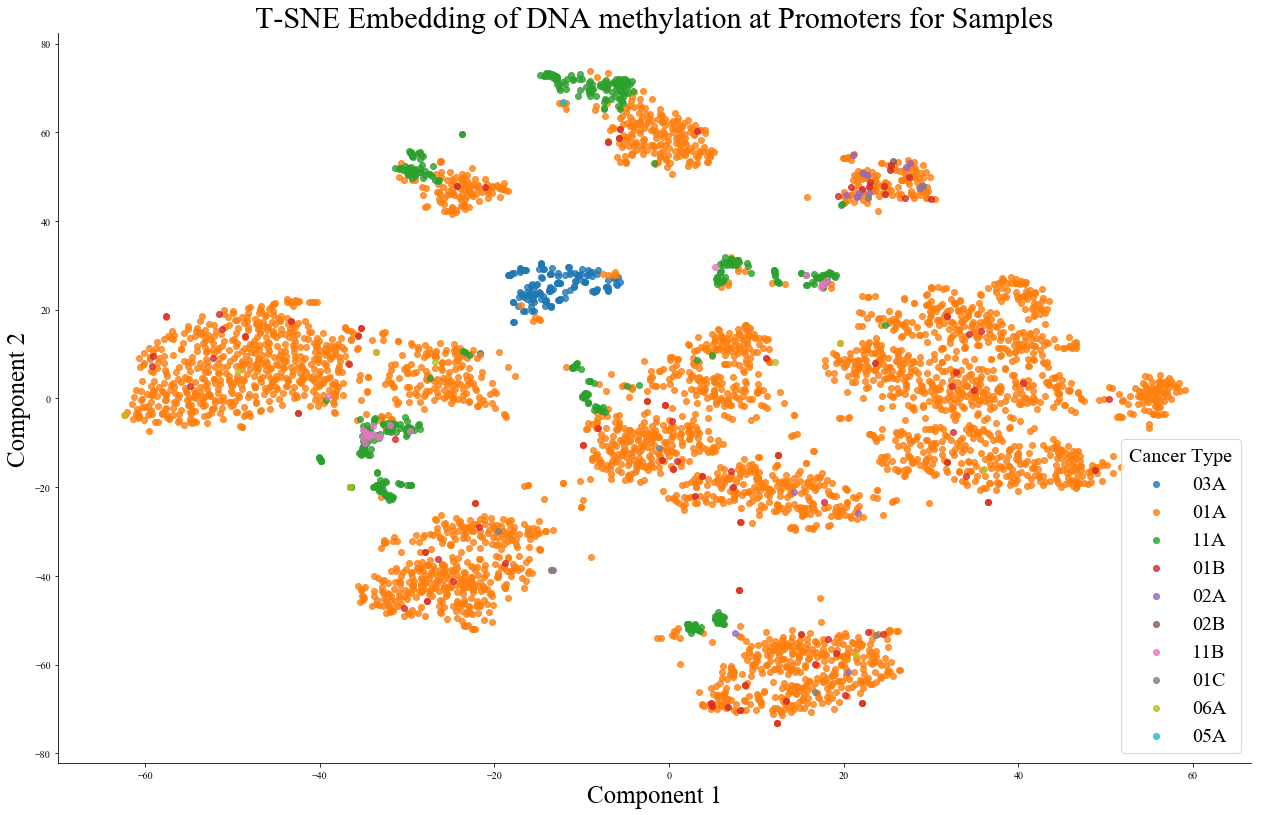

In [28]:
long = pd.DataFrame(embedding, columns=['pc1', 'pc2'], index=meth_samplewise.index)
sample_type = [n.split('|')[0].split('-')[3] for n in meth_samplewise.index if "mean_beta_value_promoter" in n]
cancer_type = [n.split('|')[1] for n in meth_samplewise.index if "mean_beta_value_promoter" in n]
long['sampletype'] = sample_type
long['cancertype'] = cancer_type
g = seaborn.lmplot(x='pc1', y='pc2', data=long, hue='sampletype', fit_reg=False, legend=False)
g.fig.set_size_inches(20, 12)
g.ax.set_xlabel('Component 1', fontsize=25)
g.ax.set_ylabel('Component 2', fontsize=25)
g.ax.legend(loc='lower right', fontsize=20, title='Cancer Type')
plt.setp(g.ax.get_legend().get_title(), fontsize=20)
plt.title('T-SNE Embedding of DNA methylation at Promoters for Samples', fontsize=30)
g.fig.savefig('../../data/pancancer/TCGA/methylation/tsne_tumor_vs_normal.png', dpi=300)